In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/7981.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/6234.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/1269.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/3863.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/6241.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/10304.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/623.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/2193.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/11925.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/3750.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/11378.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/2008.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/10730.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Do

# import Necessary Libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.image as mpimg
import os
import random
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from pathlib import Path
from random import choice
from random import seed
seed(2023)

# Define Paths and Labels

In [6]:
# Define the directory paths (adjust these paths as necessary)
base_dir = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')

# List all file names in each directory
cat_files = os.listdir(cat_dir)
dog_files = os.listdir(dog_dir)

# Create labels (0 for Cat, 1 for Dog)
cat_labels = [0] * len(cat_files)
dog_labels = [1] * len(dog_files)

# Combine the file names and labels
file_paths = cat_files + dog_files
labels = cat_labels + dog_labels

# Add the full path to each file
file_paths = [os.path.join(cat_dir, f) for f in cat_files] + [os.path.join(dog_dir, f) for f in dog_files]

print(f"Total cat images: {len(cat_files)}")
print(f"Total dog images: {len(dog_files)}")
print(f"Total images: {len(file_paths)}")


Total cat images: 12499
Total dog images: 12499
Total images: 24998


# Create the DataFrame

In [8]:
# Create file paths by combining directory and file names
cat_paths = [os.path.join(cat_dir, file) for file in cat_files]
dog_paths = [os.path.join(dog_dir, file) for file in dog_files]

# Create labels (0 for Cat, 1 for Dog)
cat_labels = ['0'] * len(cat_files)
dog_labels = ['1'] * len(dog_files)

# Combine the lists
file_paths = cat_paths + dog_paths
labels = cat_labels + dog_labels

# Create the DataFrame
df = pd.DataFrame({
    'Images_path': file_paths,
    'Label': labels
})

# Display the first few rows
df.head()

,Images_path,Label
0,Cat/7981.jpg,0
1,Cat/6234.jpg,0
2,Cat/1269.jpg,0
3,Cat/3863.jpg,0
4,Cat/6241.jpg,0


In [9]:
file_paths = cat_paths + dog_paths  # List of all image file paths
labels = cat_labels + dog_labels    # Corresponding labels for the images

# Calculate and print the lengths
input_path_length = len(file_paths)
label_length = len(labels)

print(f"Length of input_path (file_paths): {input_path_length}")
print(f"Length of label (labels): {label_length}")


Length of input_path (file_paths): 24998
Length of label (labels): 24998


In [13]:
cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')
# Function to filter .jpg files
def filter_jpg_files(directory):
    all_files = os.listdir(directory)
    jpg_files = [file for file in all_files if file.lower().endswith('.jpg')]
    return jpg_files

# Get .jpg files
cat_files = filter_jpg_files(cat_dir)
dog_files = filter_jpg_files(dog_dir)

# Create file paths
cat_paths = [os.path.join(cat_dir, file) for file in cat_files]
dog_paths = [os.path.join(dog_dir, file) for file in dog_files]

# Create labels (0 for Cat, 1 for Dog)
cat_labels = ['0'] * len(cat_files)
dog_labels = ['1'] * len(dog_files)

# Combine the lists
file_paths = cat_paths + dog_paths
labels = cat_labels + dog_labels

# Create the DataFrame
df = pd.DataFrame({
    'Images_path': file_paths,
    'Label': labels
})

# Print the total number of .jpg files
print(f"Total .jpg files: {len(file_paths)}")

Total .jpg files: 24998


# Visualize Dataset

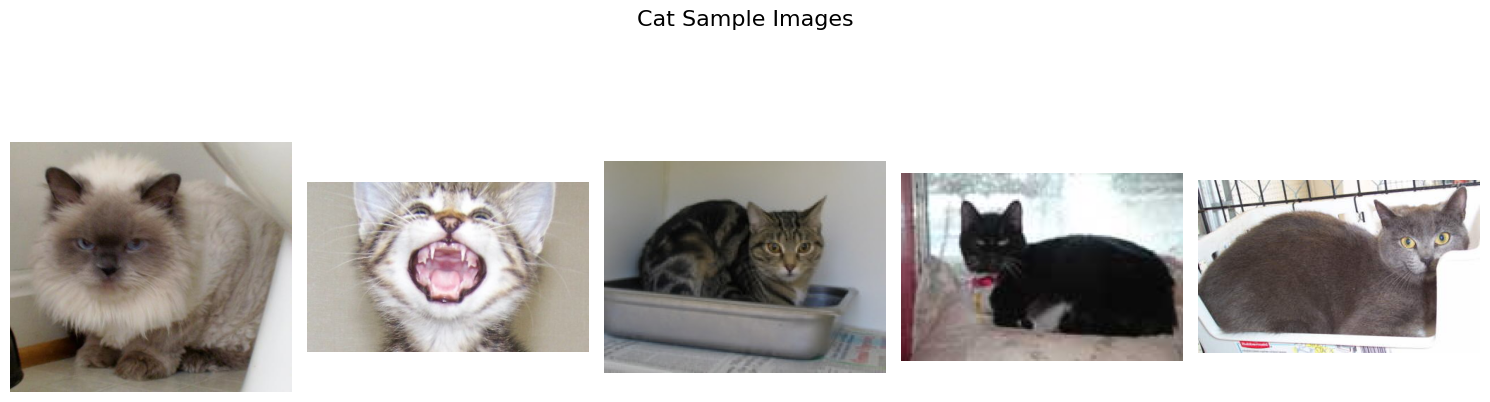

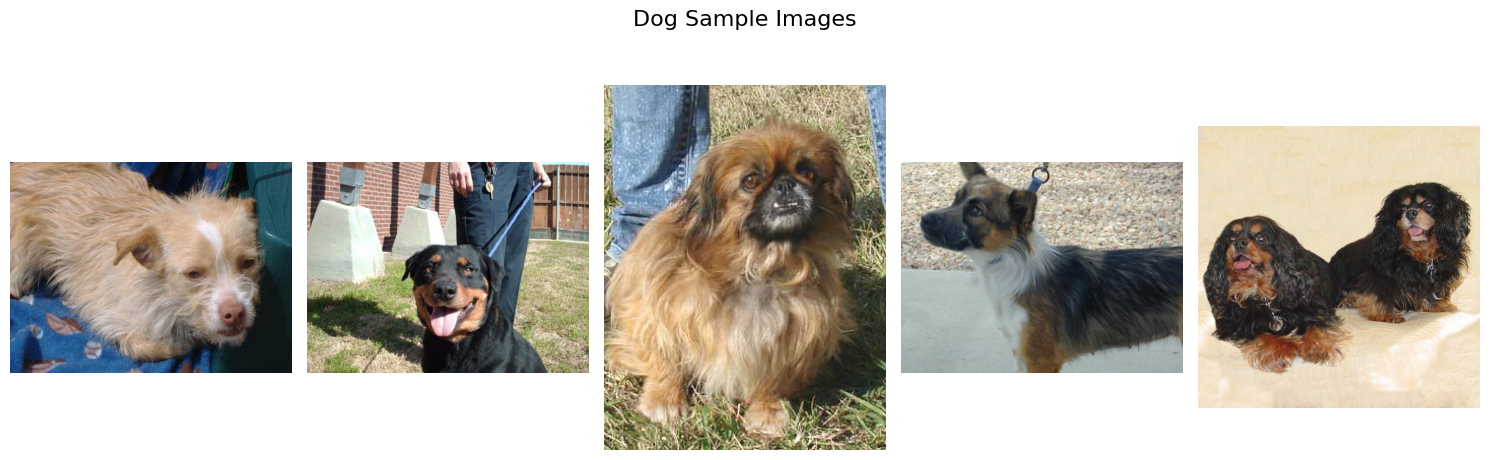

In [14]:
def display_sample_images(df, category_label, category_name, num_images=5):
    # Filter DataFrame for the specified category
    category_df = df[df['Label'] == category_label]
    
    # Randomly sample images
    sample_df = category_df.sample(n=num_images)
    
    # Set up the figure and axes for the grid
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()
    
    # Load and display images
    for img_path, ax in zip(sample_df['Images_path'], axes):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axis
        
    plt.suptitle(f'{category_name} Sample Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Display sample images for Cats and Dogs with custom titles
display_sample_images(df, '0', 'Cat')  # '0' is the label for Cats
display_sample_images(df, '1', 'Dog')  # '1' is the label for Dogs

# Spliting the dataset into training and testing

In [16]:
# Define the features and target
X = df['Images_path']
y = df['Label']

# Split the dataset into training and testing sets
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create DataFrames for training and testing sets
train_df = pd.DataFrame({
    'Images_path': X_train,
    'Label': y_train
})

test_df = pd.DataFrame({
    'Images_path': X_test,
    'Label': y_test
})

# Display the first few rows of the training and testing sets

In [17]:
print("Training set:")
train_df.head()

Training set:


,Images_path,Label
3548,/kaggle/input/dog-and-cat-classification-datas...,0
18640,/kaggle/input/dog-and-cat-classification-datas...,1
23090,/kaggle/input/dog-and-cat-classification-datas...,1
1289,/kaggle/input/dog-and-cat-classification-datas...,0
3940,/kaggle/input/dog-and-cat-classification-datas...,0


In [18]:
print("Testing set:")
test_df.head()

Testing set:


,Images_path,Label
15625,/kaggle/input/dog-and-cat-classification-datas...,1
18777,/kaggle/input/dog-and-cat-classification-datas...,1
8927,/kaggle/input/dog-and-cat-classification-datas...,0
3998,/kaggle/input/dog-and-cat-classification-datas...,0
15286,/kaggle/input/dog-and-cat-classification-datas...,1


# Create DataGenerator for the images

In [19]:
img_width, img_height = 150, 150

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create Data Generators from DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Set to None because we're using file paths from DataFrame
    x_col='Images_path',  # Column name in DataFrame for image paths
    y_col='Label',  # Column name in DataFrame for labels
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Set to None because we're using file paths from DataFrame
    x_col='Images_path',  # Column name in DataFrame for image paths
    y_col='Label',  # Column name in DataFrame for labels
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

# Display sample data
for data_batch, labels_batch in train_generator:
    print(f'Sample data shape: {data_batch.shape}')
    print(f'Sample labels shape: {labels_batch.shape}')
    break


Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Sample data shape: (32, 150, 150, 3)
Sample labels shape: (32,)


# Build the Model

In [20]:
# Define image dimensions
img_width, img_height = 150, 150

# Build the model
model = Sequential([
    Input(shape=(img_width, img_height, 3)),  # Specify input shape here
    VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
    Flatten(),  # Flatten the output from base model
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Freeze base model layers
model.layers[1].trainable = False

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [21]:
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=test_generator,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723073568.855030     218 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723073568.882456     218 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6832 - loss: 0.5658

W0000 00:00:1723073838.905045     220 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6834 - loss: 0.5656

W0000 00:00:1723073840.422327     220 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 360s 495ms/step - accuracy: 0.6836 - loss: 0.5653 - val_accuracy: 0.9168 - val_loss: 0.1904
Epoch 2/10


W0000 00:00:1723073878.079636     220 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 237ms/step - accuracy: 0.9366 - loss: 0.1582 - val_accuracy: 0.9500 - val_loss: 0.1178
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 237ms/step - accuracy: 0.9597 - loss: 0.1057 - val_accuracy: 0.9588 - val_loss: 0.1187
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 236ms/step - accuracy: 0.9680 - loss: 0.0777 - val_accuracy: 0.9522 - val_loss: 0.1175
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 236ms/step - accuracy: 0.9727 - loss: 0.0716 - val_accuracy: 0.9646 - val_loss: 0.1065
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 242ms/step - accuracy: 0.9780 - loss: 0.0557 - val_accuracy: 0.9756 - val_loss: 0.0648
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 250ms/step - accuracy: 0.9800 - loss: 0.0522 - val_accuracy: 0.9708 - val_loss: 0.0782
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 239ms/step - accuracy: 0.9803 - loss: 0.0487 - val_accuracy: 0.9694 - val_loss: 0.0977
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 236ms/step - accuracy: 0.9838 - loss: 0.04

# Visualize Training Progress

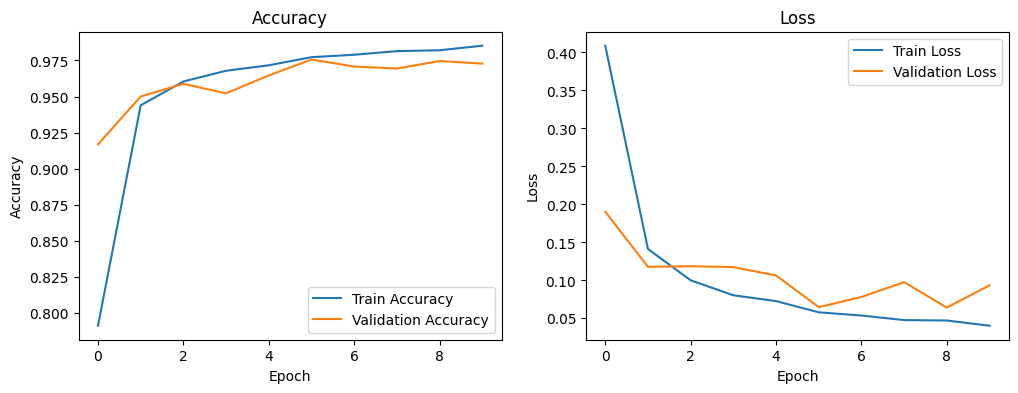

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


# Evaluating the Model

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9706 - loss: 0.1010
Test Loss: 0.09356875717639923
Test Accuracy: 0.9728000164031982


# Modeling - CNN

# Create DataGenerator for the images

In [41]:
# training data
train_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation generator
val_generator = ImageDataGenerator(
    rescale=1.0/255
)

In [44]:
# train and validation iterator
train_iterator = train_generator.flow_from_dataframe(
    train_df, 
    x_col='Images_path', 
    y_col='Label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test_df,
    x_col='Images_path', 
    y_col='Label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Build The Model

In [46]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [48]:
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,153 (9.92 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

 # Train the Model

In [49]:
history = model.fit(
    train_iterator,
    epochs=10,
    validation_data=val_iterator
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/40 ━━━━━━━━━━━━━━━━━━━━ 16:21 25s/step - accuracy: 0.3667 - loss: 0.7010

W0000 00:00:1723077788.501583     220 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/40 ━━━━━━━━━━━━━━━━━━━━ 21:48 34s/step - accuracy: 0.4158 - loss: 0.8869

W0000 00:00:1723077822.763542     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5161 - loss: 0.7326

W0000 00:00:1723077911.073371     218 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


40/40 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.5167 - loss: 0.7317 - val_accuracy: 0.5570 - val_loss: 0.6699
Epoch 2/10


W0000 00:00:1723077931.586974     218 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.6109 - loss: 0.6506 - val_accuracy: 0.6788 - val_loss: 0.5999
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6756 - loss: 0.6011 - val_accuracy: 0.7120 - val_loss: 0.5611
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.7048 - loss: 0.5700 - val_accuracy: 0.7322 - val_loss: 0.5288
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7339 - loss: 0.5335 - val_accuracy: 0.7230 - val_loss: 0.5347
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.7399 - loss: 0.5138 - val_accuracy: 0.7392 - val_loss: 0.5136
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.7566 - loss: 0.4997 - val_accuracy: 0.7588 - val_loss: 0.5069
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.7678 - loss: 0.4832 - val_accuracy: 0.7974 - val_loss: 0.4319
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.7948 - loss: 0.4378 - val_accuracy: 0.7992 - val_loss: 0.

# Visualize Training Progress

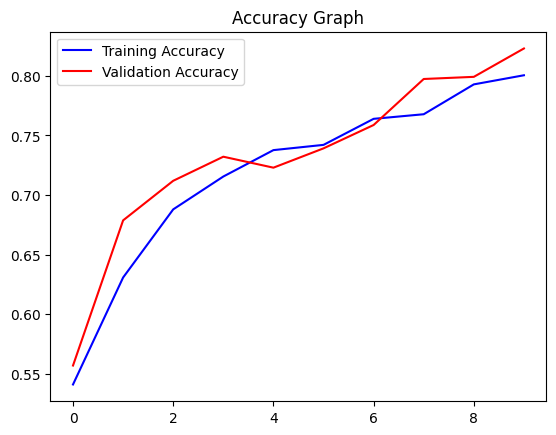

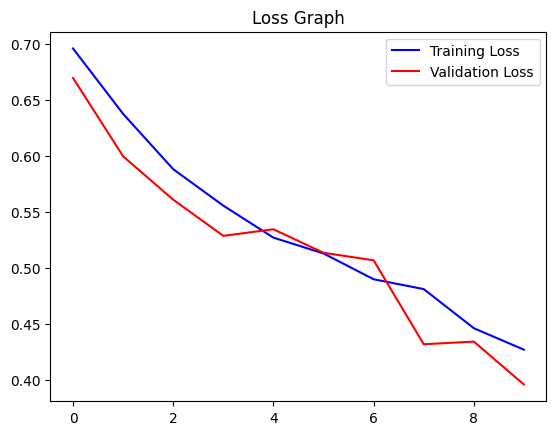

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Evaluating the Model

In [56]:
val_loss, val_acc = model.evaluate(val_iterator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8188 - loss: 0.3948
Validation Loss: 0.39589524269104004
Validation Accuracy: 0.8230000138282776
